In [39]:
# 🧠 Усі імпорти
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# 🔧 Пристрій
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Використовується пристрій:", device)

# 🧱 Клас VAE
class VAE(nn.Module):
    def __init__(self, latent_dim=16):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 400),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z).view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# 🎯 Функція втрат
reconstruction_loss_fn = nn.BCELoss(reduction='sum')
def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_loss_fn(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# 📦 Клас бінаризованого датасету з поворотами
class BinarizedRotatedMNIST(Dataset):
    def __init__(self, base_dataset, max_rotation=45, threshold=0.5):
        self.base_dataset = base_dataset
        self.max_rotation = max_rotation
        self.threshold = threshold

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image, label = self.base_dataset[idx]
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)
        theta = random.uniform(-self.max_rotation, self.max_rotation)
        transformed_image = transforms.functional.affine(
            image, angle=theta, translate=(0, 0), scale=1.0, shear=0.0, fill=0
        )
        img_tensor = transforms.ToTensor()(transformed_image)
        img_binary = (img_tensor > self.threshold).float()
        return img_binary, label, {'theta': theta}

# 📥 Завантаження MNIST та побудова датасету
base_mnist = MNIST(root='./data', train=True, download=True, transform=None)
rotated_mnist = BinarizedRotatedMNIST(base_mnist, max_rotation=45)
train_loader = DataLoader(rotated_mnist, batch_size=64, shuffle=True)

Використовується пристрій: cpu


In [125]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Стандартна трансформація для MNIST (якщо використовуєш обернені зображення — адаптуй)
transform = transforms.Compose([
    transforms.ToTensor()
])

# Тестовий набір
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [40]:
latent_dim = 9
vae_7 = VAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(vae_7.parameters(), lr=1e-3)

# Невелика кількість епох для демонстрації
num_epochs = 10
for epoch in range(num_epochs):
    vae_7.train()
    total_loss = 0
    for x, _, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = vae_7(x)
        loss = loss_function(recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Avg loss: {avg_loss:.2f}")

# Готова модель для latent_dim=7
vae_7.eval()

Epoch 1, Avg loss: 157.53
Epoch 2, Avg loss: 130.44
Epoch 3, Avg loss: 126.15
Epoch 4, Avg loss: 123.88
Epoch 5, Avg loss: 122.48
Epoch 6, Avg loss: 121.39
Epoch 7, Avg loss: 120.48
Epoch 8, Avg loss: 119.74
Epoch 9, Avg loss: 119.06
Epoch 10, Avg loss: 118.45


VAE(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=400, bias=True)
    (2): ReLU()
  )
  (fc_mu): Linear(in_features=400, out_features=9, bias=True)
  (fc_logvar): Linear(in_features=400, out_features=9, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=9, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [41]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=16):
        super(ConvVAE, self).__init__()
        # --- Енкодер ---
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),  # [B, 32, 14, 14]
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), # [B, 64, 7, 7]
            nn.ReLU()
        )
        self.flatten = nn.Flatten()  # [B, 64*7*7] = [B, 3136]
        self.fc_mu = nn.Linear(3136, latent_dim)
        self.fc_logvar = nn.Linear(3136, latent_dim)

        # --- Декодер ---
        self.fc_decode = nn.Linear(latent_dim, 3136)  # [B, 64*7*7]
        self.decoder_deconv = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),  # [B, 64, 7, 7]
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # [B, 32, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),   # [B, 1, 28, 28]
            nn.Sigmoid()
        )
    def encode(self, x):
        h = self.encoder_conv(x)
        h_flat = self.flatten(h)
        return self.fc_mu(h_flat), self.fc_logvar(h_flat)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z)
        return self.decoder_deconv(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [468]:
# 🔨 Створення моделі та оптимізатора
latent_dim = 3
vae_conv = ConvVAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(vae_conv.parameters(), lr=1e-3)

# 🎯 Функція втрат (залишається така сама)
reconstruction_loss_fn = nn.BCELoss(reduction='sum')
def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_loss_fn(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# 🔁 Цикл навчання
epochs = 5  # або більше для якісного результату
for epoch in range(epochs):
    vae_conv.train()
    total_loss = 0
    for x, _, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = vae_conv(x)
        loss = loss_function(recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Avg loss: {avg_loss:.2f}")


Epoch 1, Avg loss: 185.66
Epoch 2, Avg loss: 164.91
Epoch 3, Avg loss: 160.85
Epoch 4, Avg loss: 158.70
Epoch 5, Avg loss: 157.50


In [469]:
vae_conv.eval()
Z_all, theta_all = [], []

with torch.no_grad():
    for x, _, info in train_loader:
        x = x.to(device)
        mu, _ = vae_conv.encode(x)
        Z_all.append(mu.cpu().numpy())
        theta_all.extend(info['theta'])  # без .numpy(), бо це список
        if len(theta_all) >= 10000:
            break

Z_all = np.concatenate(Z_all)[:10000]
theta_all = np.array(theta_all)[:10000]

In [470]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

scaler = StandardScaler()
Z_scaled = scaler.fit_transform(Z_all)

reg = LinearRegression().fit(Z_scaled, theta_all)
coef = reg.coef_
r2 = r2_score(theta_all, reg.predict(Z_scaled))
max_abs = np.max(np.abs(coef))
max_idx = np.argmax(np.abs(coef))

print(f"R² = {r2:.4f}")
print(f"Найвпливовіша компонента: z[{max_idx}], коефіцієнт: {coef[max_idx]:.4f}")


R² = 0.4758
Найвпливовіша компонента: z[0], коефіцієнт: -12.4148


In [471]:
from tqdm import tqdm

vae_conv.eval()
Z_all, y_all, theta_all = [], [], []

with torch.no_grad():
    for x, y, info in tqdm(train_loader):
        x = x.to(device)
        mu, _ = vae_conv.encode(x)
        Z_all.append(mu.cpu().numpy())
        y_all.extend(y.numpy())
        theta_all.extend(info['theta'])
        if len(theta_all) >= 10000:
            break

Z_all = np.concatenate(Z_all)[:10000]
y_all = np.array(y_all)[:10000]
theta_all = np.array(theta_all)[:10000]


 17%|█████████████▎                                                                  | 156/938 [00:02<00:11, 67.62it/s]


In [472]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, adjusted_rand_score, normalized_mutual_info_score
from scipy.stats import mode

# 🔧 Кількість кластерів = 10 (по цифрах)
kmeans = KMeans(n_clusters=10, n_init=10, random_state=42)
clusters = kmeans.fit_predict(Z_all)

# 🔁 Прив'язка кластерів до міток (мапінг "кластер → цифра")
labels = np.zeros_like(clusters)
for i in range(10):
    mask = clusters == i
    if np.any(mask):
        labels[mask] = mode(y_all[mask], keepdims=True).mode[0]

acc = accuracy_score(y_all, labels)
ari = adjusted_rand_score(y_all, clusters)
nmi = normalized_mutual_info_score(y_all, clusters)

print(f"📊 Accuracy: {acc:.4f}")
print(f"🔁 ARI (Adjusted Rand Index): {ari:.4f}")
print(f"🔗 NMI (Normalized Mutual Info): {nmi:.4f}")


📊 Accuracy: 0.4168
🔁 ARI (Adjusted Rand Index): 0.1978
🔗 NMI (Normalized Mutual Info): 0.3513


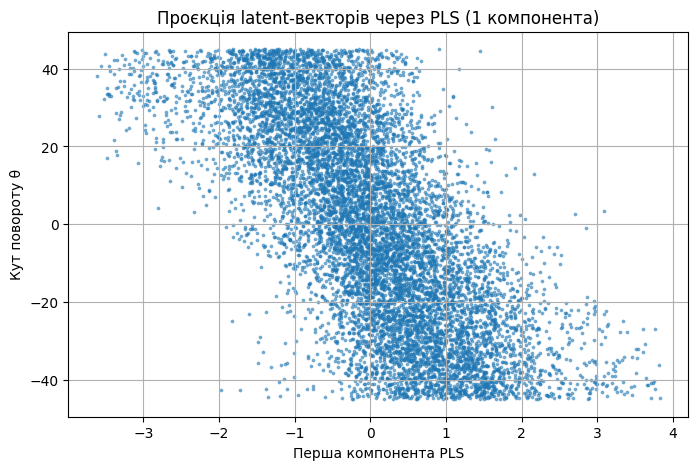

In [473]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Стандартизуємо дані
scaler = StandardScaler()
Z_scaled = scaler.fit_transform(Z_all)

theta_reshaped = theta_all.reshape(-1, 1)

# PLS з 1 компонентою
pls = PLSRegression(n_components=1)
pls.fit(Z_scaled, theta_reshaped)

# Проєкція всіх z на першу PLS-компоненту
z_pls = pls.transform(Z_scaled).squeeze()  # [10000]

# Побудова графіка
plt.figure(figsize=(8, 5))
plt.scatter(z_pls, theta_all, s=3, alpha=0.5)
plt.xlabel("Перша компонента PLS")
plt.ylabel("Кут повороту θ")
plt.title("Проєкція latent-векторів через PLS (1 компонента)")
plt.grid(True)
plt.show()


In [474]:
from sklearn.metrics import r2_score

theta_pred = pls.predict(Z_scaled).squeeze()
r2_pls = r2_score(theta_all, theta_pred)

print(f"🔍 R² для PLS (1 компонента): {r2_pls:.4f}")


🔍 R² для PLS (1 компонента): 0.4883


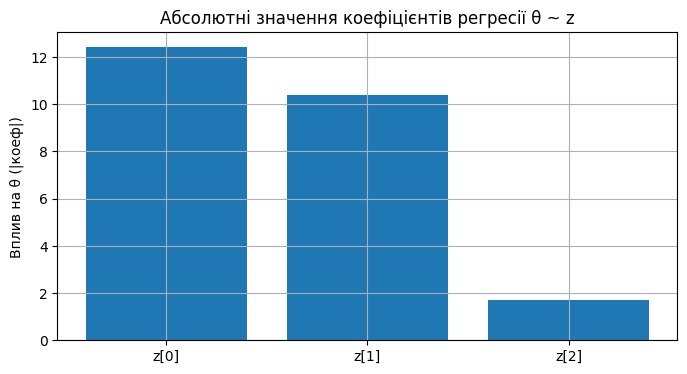

In [475]:
kk=latent_dim
plt.figure(figsize=(8, 4))
plt.bar(range(kk), np.abs(coef))
plt.xticks(range(kk), [f'z[{i}]' for i in range(kk)])
plt.title("Абсолютні значення коефіцієнтів регресії θ ~ z")
plt.ylabel("Вплив на θ (|коеф|)")
plt.grid(True)
plt.show()


In [476]:
abs_weights = np.abs(coef)
weight_contrib = abs_weights / np.sum(abs_weights)

for i, contrib in enumerate(weight_contrib):
    print(f'z[{i}]: {contrib*100:.2f}% внеску у регресію θ')


z[0]: 50.62% внеску у регресію θ
z[1]: 42.36% внеску у регресію θ
z[2]: 7.02% внеску у регресію θ


In [479]:
indices_to_keep = [1,2]  # [0,1,2,3,4,5,6,7,8,9]
Z_reduced = Z_all[:, indices_to_keep]

In [478]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

clf = LogisticRegression(max_iter=1000)
scores = cross_val_score(clf, Z_reduced, y_all, cv=5)
print(f"📊 Accuracy класифікації  : {scores.mean():.4f}")

📊 Accuracy класифікації  : 0.4775


In [480]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

clf = LogisticRegression(max_iter=1000)
scores = cross_val_score(clf, Z_reduced, y_all, cv=5)
print(f"📊 Accuracy класифікації без поворотних компонент : {scores.mean():.4f}")

📊 Accuracy класифікації без поворотних компонент : 0.3659


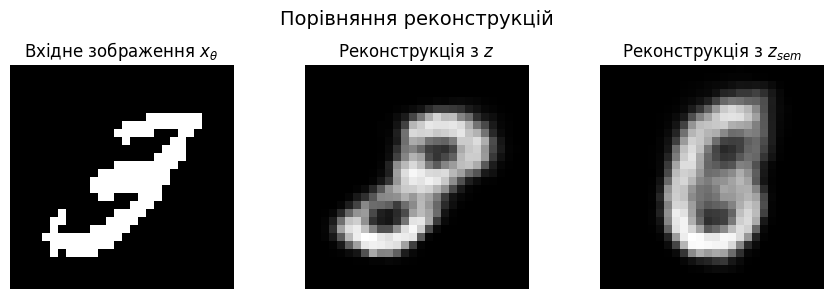

In [226]:
# 1. Вибираємо нове зображення (повернуте або як є)
x_theta = x[26].to(device).unsqueeze(0)  # розмір (1, 1, 28, 28)

# 2. Проганяємо через енкодер, щоб отримати mu
with torch.no_grad():
    mu, _ = vae_conv.encode(x_theta)
    z = mu.squeeze()  # (d,) — це базовий латентний вектор

    # 3. Занулюємо поворотні компоненти
    z_semantic = z.clone()
    z_semantic[2] = 0.0
    z_semantic[1] = 0.0
    #z_semantic[6] = 0.0

    # 4. Реконструюємо повне й семантичне
    recon_full = vae_conv.decode(z.unsqueeze(0)).cpu().squeeze().numpy()
    recon_semantic = vae_conv.decode(z_semantic.unsqueeze(0)).cpu().squeeze().numpy()

# 5. Повертаємо x_theta на CPU для візуалізації
x_img = x_theta.cpu().squeeze().numpy()

# 6. Візуалізація
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
axs[0].imshow(x_img, cmap='gray')
axs[0].set_title("Вхідне зображення $x_{\\theta}$")
axs[0].axis('off')

axs[1].imshow(recon_full, cmap='gray')
axs[1].set_title("Реконструкція з ${z}$")
axs[1].axis('off')

axs[2].imshow(recon_semantic, cmap='gray')
axs[2].set_title("Реконструкція з ${z}_{{sem}}$")
axs[2].axis('off')

plt.suptitle("Порівняння реконструкцій", fontsize=14)
plt.tight_layout()
plt.show()


In [127]:
# Створення датасету з кутом повороту
base_mnist_test = MNIST(root='./data', train=False, download=True, transform=None)
rotated_test_dataset = BinarizedRotatedMNIST(base_mnist_test, max_rotation=180)  # або 45
test_loader = DataLoader(rotated_test_dataset, batch_size=64, shuffle=False)


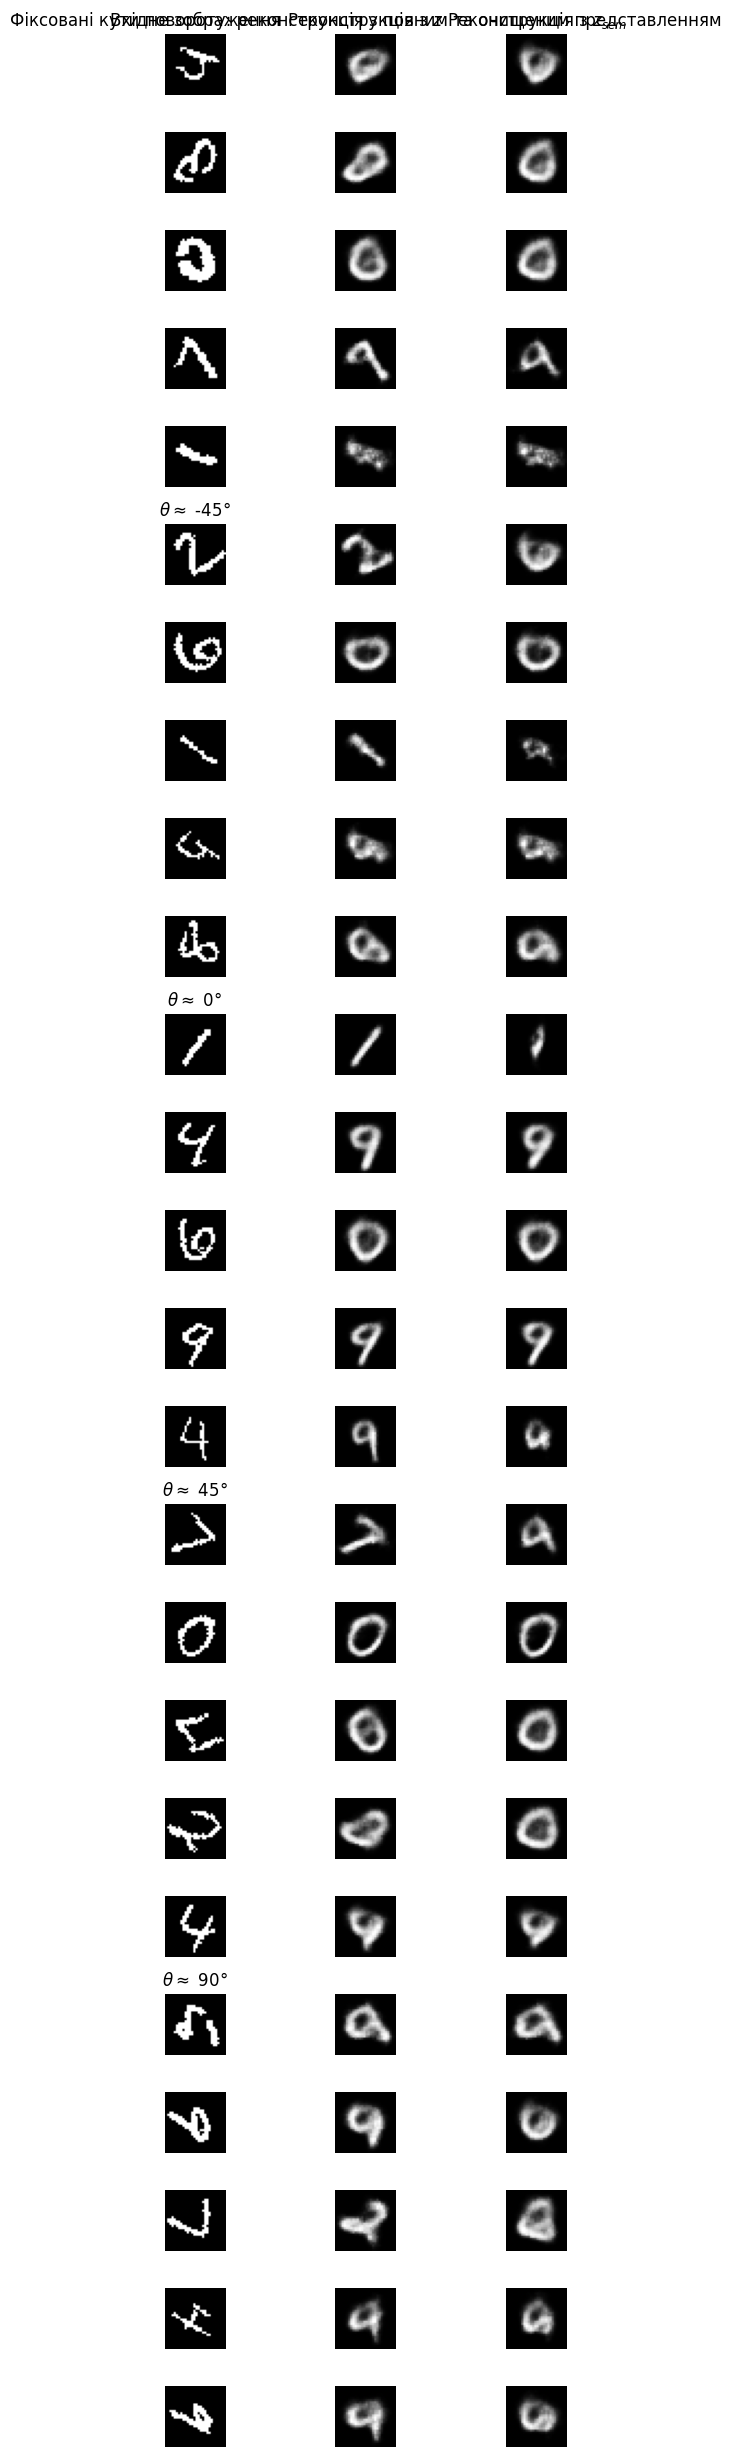

In [228]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# ⚙️ Налаштування
thetas_to_show = [-90, -45, 0, 45, 90]  # у градусах
n_per_theta = 5                        # кількість прикладів на кожне θ

# 📦 Колекція зображень для візуалізації
selected = []

# 🔄 Проходимо по test_loader і шукаємо зображення з відповідним кутом
for x_batch, _, info_batch in test_loader:
    for i in range(len(x_batch)):
        theta_deg = info_batch['theta'][i].item()
        theta_deg_rounded = int(round(theta_deg / 45) * 45)

        if theta_deg_rounded in thetas_to_show:
            selected.append((theta_deg_rounded, x_batch[i].unsqueeze(0)))  # зберігаємо (кут, зображення)

# 🔃 Групуємо по кутах
grouped = {t: [] for t in thetas_to_show}
for theta, x_img in selected:
    if len(grouped[theta]) < n_per_theta:
        grouped[theta].append(x_img)
    if all(len(grouped[t]) == n_per_theta for t in thetas_to_show):
        break

# 🖼️ Підготовка до візуалізації
fig, axs = plt.subplots(n_per_theta * len(thetas_to_show), 3, figsize=(6, n_per_theta * len(thetas_to_show)))

row = 0
for theta in thetas_to_show:
    for x_img in grouped[theta]:
        x_tensor = x_img.to(device)  # (1, 1, 28, 28)
        with torch.no_grad():
            mu, _ = vae_conv.encode(x_tensor)
            z = mu.squeeze()

            # вилучаємо компоненти повороту
            z_sem = z.clone()
            z_sem[2] = 0.0
            z_sem[1] = 0.0
            #z_sem[6] = 0.0

            recon_full = vae_conv.decode(z.unsqueeze(0)).cpu().squeeze().numpy()
            recon_sem = vae_conv.decode(z_sem.unsqueeze(0)).cpu().squeeze().numpy()
            x_input = x_tensor.cpu().squeeze().numpy()

        # Візуалізація: вхід → повне → семантичне
        axs[row, 0].imshow(x_input, cmap='gray')
        axs[row, 0].set_title(f"$\\theta \\approx$ {theta}°" if row % n_per_theta == 0 else "")
        axs[row, 1].imshow(recon_full, cmap='gray')
        axs[row, 2].imshow(recon_sem, cmap='gray')

        for col in range(3):
            axs[row, col].axis('off')

        row += 1

# 🔤 Заголовки для стовпців
axs[0, 0].set_title("Вхідне зображення")
axs[0, 1].set_title("Реконструкція з ${z}$")
axs[0, 2].set_title("Реконструкція з ${z}_{sem}$")

plt.suptitle("Фіксовані кути повороту: реконструкція з повним та очищеним представленням", fontsize=12)
plt.tight_layout()
plt.show()
